# Unified Metrics DataFrame for Experiments

This notebook provides a utility to collect both training and test metrics for a set of experiment directories, returning a pandas DataFrame. You can then use this DataFrame to create any plot you want, for any metric, using pandas or seaborn/matplotlib.

In [1]:
import os
import glob
import json
import pandas as pd
from mmengine import Config

In [2]:
def collect_experiment_metrics(
    experiment_dirs,
    config_variable_paths=None,
    train_metrics_to_track=None,
    test_metrics_to_track=None,
    proxy_values=None
):
    """
    Collects config values, last train metrics, and last test metrics for each experiment directory.

    Args:
        experiment_dirs (list): List of experiment directories.
        config_variable_paths (dict): Dict of {name: dotpath} for config variables to extract.
        train_metrics_to_track (list): List of training metric names to extract from scalars.json.
        test_metrics_to_track (list): List of test metric names to extract from test JSON.
        proxy_values (dict): Dict mapping experiment_dir to dict of {config_name: value}.

    Returns:
        pd.DataFrame: DataFrame with one row per experiment, columns for config values, train metrics, and test metrics.
    """
    rows = []
    for exp_dir in experiment_dirs:
        row = {"experiment_dir": exp_dir}
        dir_name = os.path.basename(os.path.normpath(exp_dir))
        config_file = os.path.join(exp_dir, dir_name + ".py")

        # --- Config values ---
        if config_variable_paths:
            for name, dotpath in config_variable_paths.items():
                # Proxy always overrides
                if proxy_values and exp_dir in proxy_values and name in proxy_values[exp_dir]:
                    row[name] = proxy_values[exp_dir][name]
                else:
                    try:
                        if not os.path.exists(config_file):
                            raise FileNotFoundError
                        cfg = Config.fromfile(config_file)
                        value = cfg
                        for key in dotpath.split('.'):
                            value = getattr(value, key)
                        row[name] = value
                    except Exception:
                        row[name] = None

        # --- Last train metrics (from scalars.json) ---
        if train_metrics_to_track:
            scalars_files = glob.glob(os.path.join(exp_dir, "*/vis_data/scalars.json"))
            if scalars_files:
                # Use the latest scalars.json file
                scalars_file = max(scalars_files, key=os.path.getctime)
                last_metrics = {}
                try:
                    with open(scalars_file, "r") as f:
                        for line in f:
                            try:
                                data = json.loads(line)
                                for m in train_metrics_to_track:
                                    if m in data:
                                        last_metrics[m] = data[m]
                            except Exception:
                                continue
                    for m in train_metrics_to_track:
                        row[f"train_{m}"] = last_metrics.get(m, None)
                except Exception:
                    for m in train_metrics_to_track:
                        row[f"train_{m}"] = None
            else:
                for m in train_metrics_to_track:
                    row[f"train_{m}"] = None

        # --- Last test metrics (from test JSON) ---
        if test_metrics_to_track:
            # Find timestamped subdirs, sort by ctime
            timestamp_dirs = [d for d in glob.glob(os.path.join(exp_dir, '*/')) if os.path.isdir(d)]
            sorted_timestamp_dirs = sorted(timestamp_dirs, key=os.path.getctime, reverse=True)
            test_metrics = None
            for timestamp_dir in sorted_timestamp_dirs:
                timestamp = os.path.basename(os.path.normpath(timestamp_dir))
                json_file = os.path.join(timestamp_dir, f"{timestamp}.json")
                if os.path.exists(json_file):
                    try:
                        with open(json_file, "r") as f:
                            test_metrics = json.load(f)
                        break
                    except Exception:
                        continue
            for m in test_metrics_to_track:
                row[f"test_{m}"] = test_metrics.get(m, None) if test_metrics else None

        rows.append(row)
    return pd.DataFrame(rows)

## Example: Collect and Plot Metrics

You can now use the DataFrame to plot any metric vs. any config value, using pandas, matplotlib, or seaborn.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

experiment_dirs = [
    "../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func",
    "../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl1-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl2-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl3-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl5-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl20-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl30-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl50-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl100-sep-eucl_improved_8xb2-36e_aircraft-func",
]

proxy_values = {
    "../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func": {"decay": 1000},
    "../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func": {"decay": 1000},
}

df = collect_experiment_metrics(
    experiment_dirs,
    config_variable_paths={"decay": "model.bbox_head.loss_cls.decay"},
    train_metrics_to_track=["coco/bbox_mAP", "coco/bbox_AR@100", "coco/bbox_mF1"],
    test_metrics_to_track=["coco/bbox_mAP", "coco/bbox_AR@100", "coco/bbox_mF1"],
    proxy_values=proxy_values
)

In [11]:
def plot_metrics_vs_config(
    df,
    metrics,
    labels,
    proxy_values,
    x="decay",
    xscale="log",
    title="Decay vs. Test Metrics",
    xlabel="Decay",
    ylabel="Metric Value",
    figsize=(6, 4),  # Changed default to (6, 4) for double column fit
    legend_fontsize=10,  # Slightly smaller for compactness
    title_fontsize=13,  # Good for double column
    label_fontsize=12   # Good for double column
):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.colors as mcolors
    markers = ['o', 's', '^', 'D', '*']
    plt.figure(figsize=figsize)
    ax = plt.gca()
    for i, metric in enumerate(metrics):
        df_sorted = df.sort_values(x)
        is_proxy = df_sorted[x].isin([
            v[x] for v in proxy_values.values() if x in v
        ])
        real = df_sorted[~is_proxy]
        proxy = df_sorted[is_proxy]
        color = sns.color_palette()[i % len(sns.color_palette())]
        # Plot line for real points
        if not real.empty:
            all_real = real[[x, metric]].dropna()
            ax.plot(all_real[x], all_real[metric], linestyle='--', color=color, alpha=0.7, zorder=1)
            ax.plot(all_real[x], all_real[metric], marker=markers[i % len(markers)], linestyle='None', label=labels.get(metric, metric), zorder=2, color=color)
            line_color = color
        else:
            line_color = color
        # Proxy points and lines: desaturate
        if not proxy.empty:
            gray_val = 0.5
            proxy_color = [c * 0.5 + gray_val * 0.5 for c in mcolors.to_rgb(line_color)]
            all_proxy = proxy[[x, metric]].dropna()
            # Draw desaturated line for proxies
            if len(all_proxy) > 1:
                ax.plot(all_proxy[x], all_proxy[metric], linestyle='--', color=proxy_color, alpha=0.7, zorder=1)
            ax.scatter(all_proxy[x], all_proxy[metric], marker=markers[i % len(markers)], color=proxy_color, label=f"Proxy {labels.get(metric, metric)}", zorder=3, alpha=0.7)
            # Connect last real to first proxy with desaturated line if both exist
            if not real.empty and not all_proxy.empty:
                last_real_x = all_real[x].iloc[-1]
                last_real_y = all_real[metric].iloc[-1]
                first_proxy_x = all_proxy[x].iloc[0]
                first_proxy_y = all_proxy[metric].iloc[0]
                ax.plot([last_real_x, first_proxy_x], [last_real_y, first_proxy_y], linestyle='--', color=proxy_color, alpha=0.7, zorder=1)
    if xscale == 'log':
        ax.set_xscale('log')
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=label_fontsize)
    ax.legend(fontsize=legend_fontsize)
    plt.tight_layout()
    plt.show()

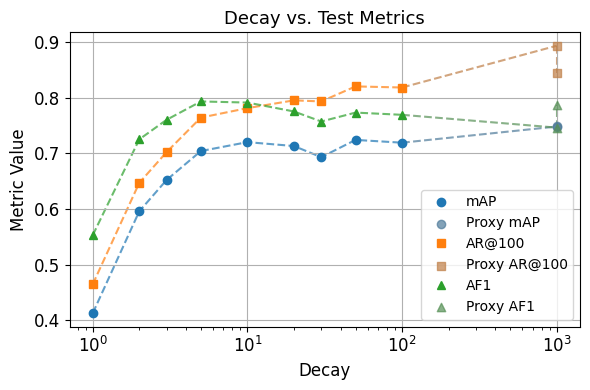

In [12]:
# Example usage:
metrics = ["test_coco/bbox_mAP", "test_coco/bbox_AR@100", "test_coco/bbox_mF1"]
labels = {"test_coco/bbox_mAP": "mAP", "test_coco/bbox_AR@100": "AR@100", "test_coco/bbox_mF1": "AF1"}
plot_metrics_vs_config(df, metrics, labels, proxy_values, x="decay")

In [13]:
display(df)

,experiment_dir,decay,train_coco/bbox_mAP,train_coco/bbox_AR@100,train_coco/bbox_mF1,test_coco/bbox_mAP,test_coco/bbox_AR@100,test_coco/bbox_mF1
0,../work_dirs/dino-r50_improved_8xb2-36e_aircra...,1000,0.483,0.824,0.580,0.748,0.893,0.746
1,../work_dirs/embed_dino-r50-sep-eucl_improved_...,1000,0.491,0.769,0.629,0.749,0.844,0.786
2,../work_dirs/hi_dino-r50-hfl1-sep-eucl_improve...,1,0.380,0.434,0.544,0.413,0.465,0.553
3,../work_dirs/hi_dino-r50-hfl2-sep-eucl_improve...,2,0.591,0.643,0.726,0.596,0.647,0.725
4,../work_dirs/hi_dino-r50-hfl3-sep-eucl_improve...,3,0.636,0.705,0.756,0.652,0.702,0.760
5,../work_dirs/hi_dino-r50-hfl5-sep-eucl_improve...,5,0.685,0.756,0.782,0.704,0.764,0.793
6,../work_dirs/hi_dino-r50-hfl10-sep-eucl_improv...,10,0.710,0.784,0.791,0.720,0.781,0.791
7,../work_dirs/hi_dino-r50-hfl20-sep-eucl_improv...,20,0.699,0.789,0.773,0.713,0.795,0.775
8,../work_dirs/hi_dino-r50-hfl30-sep-eucl_improv...,30,0.710,0.796,0.777,0.693,0.793,0.757
9,../work_dirs/hi_dino-r50-hfl50-sep-eucl_improv...,50,0.682,0.808,0.756,0.724,0.820,0.773


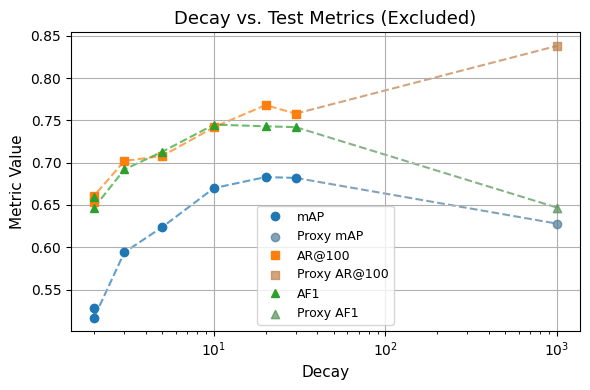

In [35]:
# Collect and plot for the 'excluded' experiment set
excluded_experiment_dirs = [
    "../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64",
    # "../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64",
    "../work_dirs/hi_dino-r50-hfl1-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64",
    "../work_dirs/hi_dino-r50-hfl2-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64",
    "../work_dirs/hi_dino-r50-hfl3-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64",
    "../work_dirs/hi_dino-r50-hfl5-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64",
    "../work_dirs/hi_dino-r50-hfl10-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64",
    "../work_dirs/hi_dino-r50-hfl20-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64",
    "../work_dirs/hi_dino-r50-hfl30-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64",
    "../work_dirs/hi_dino-r50-hfl50-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64",
]

excluded_proxy_values = {
    "../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64": {"decay": 1000},
    "../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64": {"decay": 1000},
}

excluded_df = collect_experiment_metrics(
    excluded_experiment_dirs,
    config_variable_paths={"decay": "model.bbox_head.loss_cls.decay"},
    train_metrics_to_track=["coco/bbox_mAP", "coco/bbox_AR@100", "coco/bbox_mF1"],
    test_metrics_to_track=["coco/bbox_mAP", "coco/bbox_AR@100", "coco/bbox_mF1"],
    proxy_values=excluded_proxy_values
)

metrics = ["test_coco/bbox_mAP", "test_coco/bbox_AR@100", "test_coco/bbox_mF1"]
labels = {"test_coco/bbox_mAP": "mAP", "test_coco/bbox_AR@100": "AR@100", "test_coco/bbox_mF1": "AF1"}
plot_metrics_vs_config(excluded_df, metrics, labels, excluded_proxy_values, x="decay", title="Decay vs. Test Metrics (Excluded)")

In [32]:
display(excluded_df)

,experiment_dir,decay,train_coco/bbox_mAP,train_coco/bbox_AR@100,train_coco/bbox_mF1,test_coco/bbox_mAP,test_coco/bbox_AR@100,test_coco/bbox_mF1
0,../work_dirs/dino-r50_improved_8xb2-36e_aircra...,1000,0.647,0.854,0.660,0.628,0.838,0.647
1,../work_dirs/hi_dino-r50-hfl1-ecl-sep-eucl_imp...,2,0.443,0.810,0.482,0.528,0.653,0.660
2,../work_dirs/hi_dino-r50-hfl2-ecl-sep-eucl_imp...,2,0.437,0.814,0.471,0.517,0.661,0.647
3,../work_dirs/hi_dino-r50-hfl3-ecl-sep-eucl_imp...,3,0.621,0.724,0.714,0.594,0.702,0.692
4,../work_dirs/hi_dino-r50-hfl5-ecl-sep-eucl_imp...,5,0.650,0.731,0.735,0.624,0.708,0.713
5,../work_dirs/hi_dino-r50-hfl10-ecl-sep-eucl_im...,10,0.680,0.753,0.752,0.670,0.742,0.745
6,../work_dirs/hi_dino-r50-hfl20-ecl-sep-eucl_im...,20,0.701,0.782,0.758,0.683,0.768,0.743
7,../work_dirs/hi_dino-r50-hfl30-ecl-sep-eucl_im...,30,0.709,0.783,0.765,0.682,0.758,0.742
8,../work_dirs/hi_dino-r50-hfl50-ecl-sep-eucl_im...,50,0.549,0.772,0.630,NaN,NaN,NaN
